# NicheCompass Single Sample Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 17.05.2023
- **Date of Last Modification:** 17.05.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_ligand_target_mx,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sbirk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sbirk/miniconda3/envs/nichecompass/lib/python3.9/site-

### 1.2 Define Parameters

In [2]:
### Dataset ###
spatial_key = "spatial"

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_sources_mask_key = "nichecompass_gp_sources"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.1
node_label_method = "one-hop-attention" # choose one-hop-norm for significant speed up of model training

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 30.
edge_batch_size = 2048

### Analysis ###
cell_type_key = "celltype_mapped_refined"
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [17]:
# Define paths
gp_data_folder_path = "../data/gene_programs"
omnipath_ligand_receptor_interactions_file_path = f"{gp_data_folder_path}/omnipath_lr_interactions.csv"
nichenet_ligand_target_interactions_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
artifacts_folder_path = f"../artifacts"
figure_folder_path = f"{artifacts_folder_path}/figures"
model_folder_path = f"{artifacts_folder_path}/models"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset and application of interest.

In [5]:
# Retrieve example adata from squidpy
adata = sq.datasets.seqfish()

# Store raw counts in `layers`
adata.layers["counts"] = adata.X.copy()

In [6]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=12)

### 2.2 Explore Data

Number of nodes (observations): 19416
Number of node features (genes): 351


/home/sbirk/miniconda3/envs/nichecompass/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


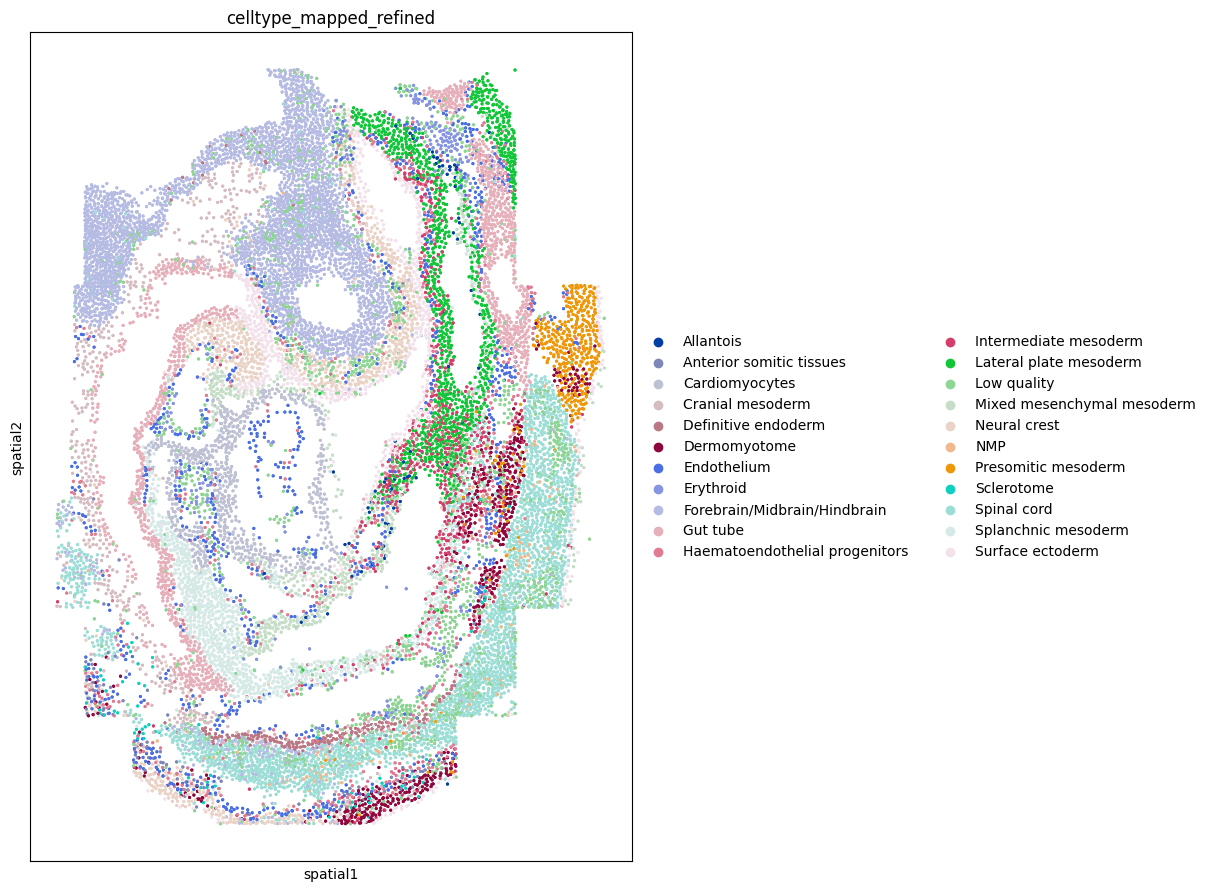

In [7]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize adata in spatial space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Train Autotalker Model with Prior Knowledge Cell-Cell-Interaction Gene Programs (GPs)

The user can provide a custom CGP mask to NicheCompass based on the dataset and hypothesis of interest. 

As a default, we create a CGP mask based on three databases of prior cell-cell-interaction knowledge:
- OmniPath
- NicheNet
- MEBOCOST

### 3.1 Create Prior Knowledge Cell-Cell-Interaction GP Mask

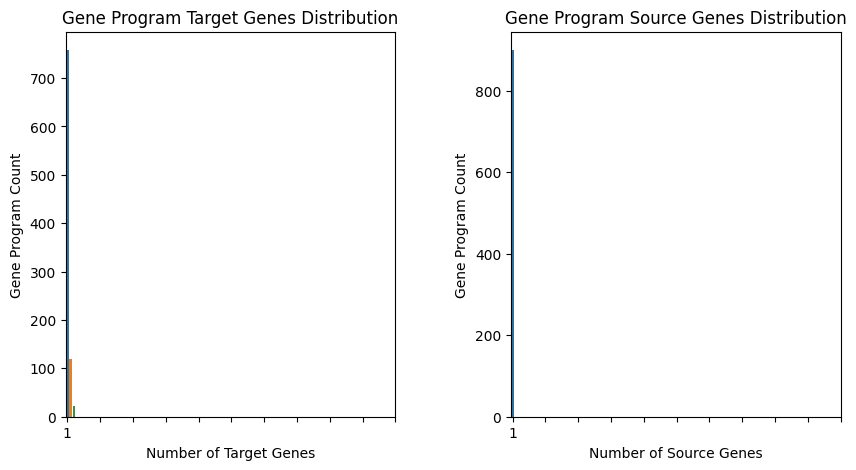

In [8]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_ligand_receptor_interactions_file_path,
    plot_gp_gene_count_distributions=True)

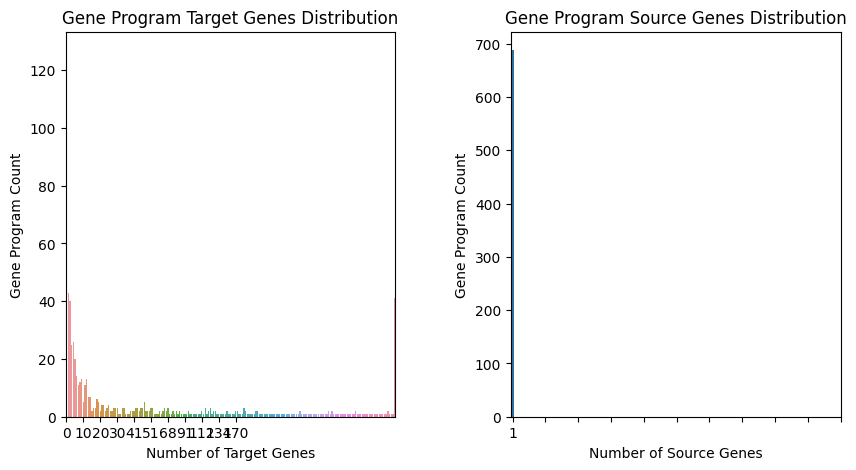

In [9]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=1000,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_interactions_file_path,
    plot_gp_gene_count_distributions=True)

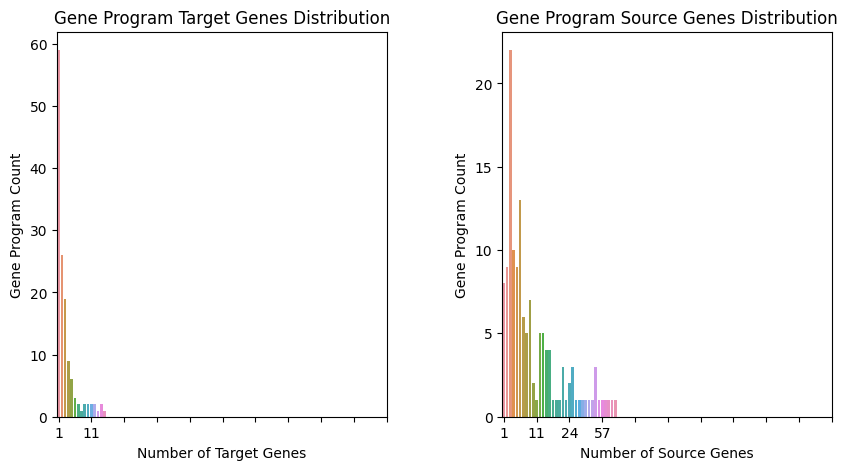

In [10]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species="mouse",
    plot_gp_gene_count_distributions=True)

In [11]:
# Add GPs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [12]:
# Filter and combine GPs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1583.


In [13]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 3.2 Initialize, Train & Save Model

In [14]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     latent_key=latent_key,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.1
LOG VARIATIONAL -> True
ENCODER -> n_input: 351, n_cond_embed_input: 0, n_layers: 1, n_hidden: 458, n_latent: 458, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 458, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 458, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702
ONE HOP ATTENTION NODE LABEL AGGREGATOR -> n_input: 351, n_heads: 4, self_loops: True


In [15]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size)


--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 105610
Number of validation edges: 11734

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% train_global_loss: 401557.4838; train_optim_loss: 401557.4838; val_global_loss: 371216.5260; val_optim_loss: 371216.5260
Epoch 2/100 |--------------------| 2.0% train_global_loss: 366285.2007; train_optim_loss: 366285.2007; val_global_loss: 362075.9583; val_optim_loss: 362075.9583
Epoch 3/100 |--------------------| 3.0% train_global_loss: 360175.0811; train_optim_loss: 360175.0811; val_global_loss: 359371.2708; val_optim_loss: 359371.2708
Epoch 4/100 |--------------------| 4.0% train_global_loss: 357556.9808; train_optim_loss: 357556.9808; val_global_loss: 357229.8646; val_optim_loss: 357229.8646
Epoch 5/100 |█-------------------| 5.0% train_global_loss: 355626.3347; train_optim_loss: 355626.3347; val_global_loss: 356095.2188; val_optim_loss: 356095.2188
Epoch 6/1

In [16]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)


# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [18]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name=f"adata.h5ad")

## 4. Analysis

### 4.2 Latent Leiden Cluster Annotations in Latent and Spatial Space

### 4.3 GP Enrichments

#### 4.3.1 Cell-type GP Enrichments

##### 4.3.1.1 Explore All GPs Across All Categories

##### 4.3.1.2 Explore All GPs Across Specific Categories

##### 4.3.1.3 Explore Specific GPs

#### 4.3.2 Spatial GP Enrichments